In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets
from nilearn.plotting import plot_surf_stat_map, view_surf
from nilearn.signal import clean
import matplotlib.pyplot as plt

DERIVS = Path("/home/Datasets/stateswitch/derivatives")
SUBJECT = "sub-008"
SESSION = "ses-04"
TASK = "sceneprf"
HEMIS = ["L", "R"]                     # do one at a time or both
SURF_FOR_PLOT = "inflated"             # "inflated" or "pial"
BG_SCALAR = "sulc"                     # "sulc" or "curv"

fs6 = datasets.fetch_surf_fsaverage('fsaverage6')

[fetch_surf_fsaverage] Dataset found in /home/zli230/nilearn_data/fsaverage6


In [2]:
def find_runs_surface(derivs, subject, session, task, hemi):
    # example: sub-001_ses-04_task-sceneprf_run-5_hemi-R_space-fsaverage6_bold.func.gii
    pat = f"{subject}/{session}/**/{subject}_{session}_task-{task}_run-*_hemi-{hemi}_space-fsaverage6_bold.func.gii"
    paths = list(derivs.rglob(pat))

    # sort by run number
    def run_idx(p):
        m = re.search(r"run-(\d+)", p.name)
        return int(m.group(1)) if m else 1
    return sorted(paths, key=run_idx)

hemi_runs = {h: find_runs_surface(DERIVS, SUBJECT, SESSION, TASK, h) for h in HEMIS}
for h, lst in hemi_runs.items():
    print(f"hemi-{h}: {len(lst)} runs")
    for p in lst:
        print("  -", p)


hemi-L: 5 runs
  - /home/Datasets/stateswitch/derivatives/sub-008/ses-04/func/sub-008_ses-04_task-sceneprf_run-1_hemi-L_space-fsaverage6_bold.func.gii
  - /home/Datasets/stateswitch/derivatives/sub-008/ses-04/func/sub-008_ses-04_task-sceneprf_run-2_hemi-L_space-fsaverage6_bold.func.gii
  - /home/Datasets/stateswitch/derivatives/sub-008/ses-04/func/sub-008_ses-04_task-sceneprf_run-3_hemi-L_space-fsaverage6_bold.func.gii
  - /home/Datasets/stateswitch/derivatives/sub-008/ses-04/func/sub-008_ses-04_task-sceneprf_run-4_hemi-L_space-fsaverage6_bold.func.gii
  - /home/Datasets/stateswitch/derivatives/sub-008/ses-04/func/sub-008_ses-04_task-sceneprf_run-5_hemi-L_space-fsaverage6_bold.func.gii
hemi-R: 5 runs
  - /home/Datasets/stateswitch/derivatives/sub-008/ses-04/func/sub-008_ses-04_task-sceneprf_run-1_hemi-R_space-fsaverage6_bold.func.gii
  - /home/Datasets/stateswitch/derivatives/sub-008/ses-04/func/sub-008_ses-04_task-sceneprf_run-2_hemi-R_space-fsaverage6_bold.func.gii
  - /home/Datasets

In [3]:
def load_func_gii_timeseries(fp):
    g = nib.load(str(fp))
    # each darray = one time point with V vertices
    arrs = [da.data for da in g.darrays]              # list of (V,)
    data = np.vstack([a[np.newaxis, :] for a in arrs])# (T, V)
    return data.astype(np.float32)

In [4]:
from nilearn.signal import clean
import numpy as np

def prepare_runs(run_paths, tr=1.5, total_dur=248.0, high_pass=0.01):
    """
    Load each .func.gii run, trim to first total_dur seconds (~165 TRs for TR=1.5s),
    apply a 0.01 Hz high-pass, and z-score each vertex over time.
    Returns: zts_list (list of (T,V) arrays), min_T
    """
    n_tr_keep = int(round(total_dur / tr))   # 248/1.5 ≈ 165
    ts_list = []
    for fp in run_paths:
        ts = load_func_gii_timeseries(fp)    # (T, V), float32 from loader preferred
        ts = ts[:min(ts.shape[0], n_tr_keep)]
        ts_list.append(ts)

    # equalize time length across runs
    min_T = min(ts.shape[0] for ts in ts_list)
    ts_list = [ts[:min_T] for ts in ts_list]

    # high-pass + detrend + z-score per run
    zts_list = [
        clean(
            ts.astype(np.float32, copy=False),
            t_r=tr,
            detrend=True,
            standardize='zscore_sample',
            high_pass=high_pass,
            low_pass=None,
        ).astype(np.float32, copy=False)
        for ts in ts_list
    ]

    print(f"Trimmed to {min_T} TRs (~{min_T*tr:.1f}s), high-pass={high_pass} Hz")
    return zts_list, min_T

# run it per hemisphere
hemi_data = {}
for h in HEMIS:
    if not hemi_runs[h]:
        continue
    zts_list, min_T = prepare_runs(hemi_runs[h], tr=1.5, total_dur=248.0, high_pass=0.01)
    T, V = zts_list[0].shape
    print(f"hemi-{h}: runs={len(zts_list)}, T={T}, V={V}")
    hemi_data[h] = {"zts_list": zts_list, "run_paths": hemi_runs[h]}


Trimmed to 165 TRs (~247.5s), high-pass=0.01 Hz
hemi-L: runs=5, T=165, V=40962
Trimmed to 165 TRs (~247.5s), high-pass=0.01 Hz
hemi-R: runs=5, T=165, V=40962


In [5]:
# Fast inter-run correlation (IRC) per hemisphere: run vs mean(other runs), averaged over runs
hemi_irc = {}

for h, data in hemi_data.items():
    zts_list = data["zts_list"]          # list of (T, V), already trimmed + z-scored
    Z = np.stack(zts_list, axis=0).astype(np.float32)  # (n, T, V)
    n, T, V = Z.shape

    # mean over runs (T, V)
    mean_all = Z.mean(axis=0)

    # For each run i:
    # r_i(v) = corr( Zi, mean_others ) with mean_others = (n*mean_all - Zi)/(n-1)
    # Using z-scored data, corr over time ≈ mean_t(product)
    # => r_i(v) = n/(n-1)*⟨Zi,mean_all⟩ - 1/(n-1)*⟨Zi,Zi⟩, where ⟨A,B⟩ = mean over time of A*B

    dot_with_mean = np.einsum('ntv,tv->nv', Z, mean_all) / T   # (n, V)
    dot_self      = np.einsum('ntv,ntv->nv', Z, Z) / T         # (n, V)

    corr_each = (n/(n-1)) * dot_with_mean - (1/(n-1)) * dot_self   # (n, V)
    irc = corr_each.mean(axis=0).astype(np.float32)                 # (V,)

    hemi_irc[h] = np.where(np.isfinite(irc), irc, 0.0)
    print(f"hemi-{h}: computed IRC for {V} vertices (vectorized)")


hemi-L: computed IRC for 40962 vertices (vectorized)
hemi-R: computed IRC for 40962 vertices (vectorized)


[fetch_surf_fsaverage] Dataset found in /home/zli230/nilearn_data/fsaverage6


/tmp/ipykernel_2254075/581635516.py:34: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(


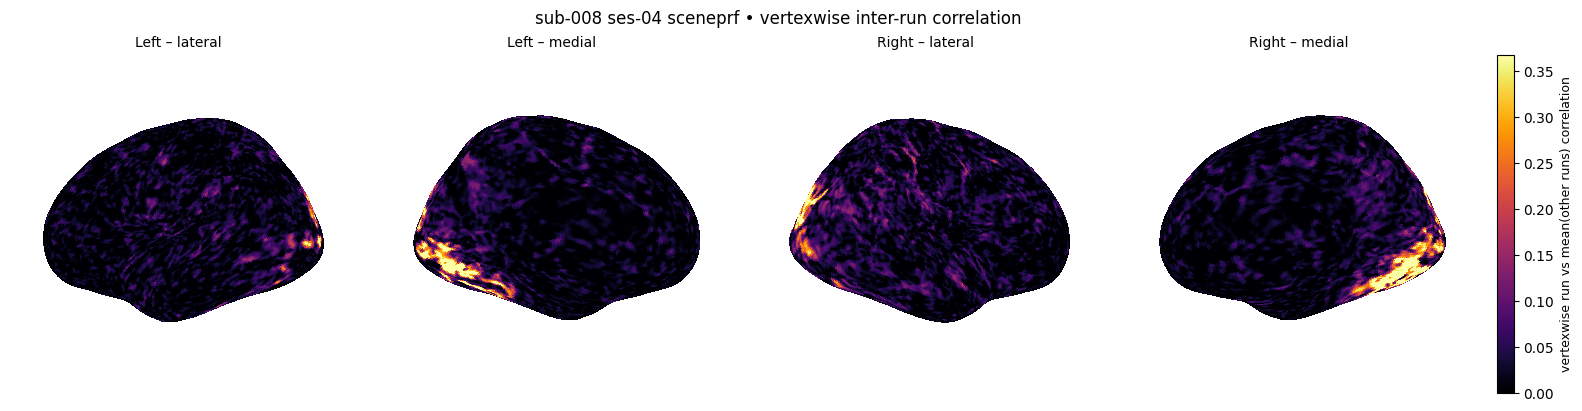

In [6]:
import matplotlib.pyplot as plt
from nilearn import datasets, plotting

# 1) Fetch fsaverage6 meshes and sulcal background
fs6 = datasets.fetch_surf_fsaverage('fsaverage6')

# 2) Assemble what you have
irc_L = hemi_irc.get("L", None)
irc_R = hemi_irc.get("R", None)

# 3) Robust display range
vals = np.concatenate([x for x in [irc_L, irc_R] if x is not None])
vmin, vmax = 0.0, float(np.nanpercentile(vals, 99))  # robust upper bound
vmax = max(vmax, 0.2)

# 4) Collect meshes/bg per view
views = [
    ("L", fs6.infl_left, fs6.sulc_left, "left", "lateral"),
    ("L", fs6.infl_left, fs6.sulc_left, "left", "medial"),
    ("R", fs6.infl_right, fs6.sulc_right, "right", "lateral"),
    ("R", fs6.infl_right, fs6.sulc_right, "right", "medial"),
]

# 5) Set up the 1×4 subplot
fig, axes = plt.subplots(1, 4, figsize=(16, 4),
                         subplot_kw={"projection": "3d"},
                         constrained_layout=True)

for ax, (h, mesh, bg, hemi_name, view) in zip(axes, views):
    irc = hemi_irc.get(h)
    if irc is None:
        ax.set_visible(False)
        continue
    plotting.plot_surf_stat_map(
        surf_mesh=mesh,
        stat_map=irc,
        hemi=hemi_name,
        bg_map=bg,
        cmap="inferno",
        vmin=vmin, vmax=vmax,
        colorbar=False,  # we'll add one shared bar
        axes=ax,
        view=view,
    )
    ax.set_title(f"{hemi_name.capitalize()} – {view}", fontsize=10)

# Shared colorbar
sm = plt.cm.ScalarMappable(cmap="inferno")
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=axes, fraction=0.025, pad=0.02)
cbar.set_label("vertexwise run vs mean(other runs) correlation", fontsize=9)

fig.suptitle(f"{SUBJECT} {SESSION} {TASK} • vertexwise inter-run correlation", fontsize=12)
plt.show()
